In [96]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import os
from numpy.linalg import inv

In [97]:
leads          = np.arange(0,25,1)    # Time ahead (in years) to forecast AMV
resolution     = '2deg'               # Resolution of input (2deg or full)
season         = 'Ann'                # Season to take mean over
indexregion    = 'NAT'                # One of the following ("SPG","STG","TRO","NAT")

In [98]:
# Training/Testing Subsets
percent_train = 0.8   # Percentage of data to use for training (remaining for testing)
ens           = 40    # Ensemble members to use
channels = 3
batch_size = 32

In [99]:
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index

In [100]:
# Load the data for whole North Atlantic
sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
sss_normed = np.load('../../CESM_data/CESM_sss_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
psl_normed = np.load('../../CESM_data/CESM_psl_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
invars = [sst_normed,sss_normed,psl_normed]

In [101]:
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))
nens,tstep,nlat,nlon = sst_normed.shape

In [105]:
corr_grid_test = []
corr_grid_train = []


leads = np.arange(0,25,1)

for lead in leads:
    y = calc_AMV_index(indexregion,sst_normed[:ens,lead:,:,:],lat,lon)
    y = y.reshape((y.shape[0]*y.shape[1]))[:,None]
    X = np.transpose(
        np.array(invars)[:,:ens,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*ens,nlat,nlon),
        (1,0,2,3))
    X = np.mean(X,axis=(2,3))
    X_train =  X[0:int(np.floor(percent_train*(tstep-lead)*ens)),:].T
    X_val =  X[int(np.floor(percent_train*(tstep-lead)*ens)):,:].T
    y_train =  y[0:int(np.floor(percent_train*(tstep-lead)*ens)),:]
    y_val =  y[int(np.floor(percent_train*(tstep-lead)*ens)):,:] 


    theta = (inv(X_train @ X_train.T) @ X_train ) @ y_train
    y_pred_train = (theta.T @ X_train).T
    y_pred_val = (theta.T @ X_val).T
    corr_grid_train.append( np.corrcoef(y_pred_train[:,0], y_train[:,0])[0,1] )
    corr_grid_test.append( np.corrcoef(y_pred_val[:,0], y_val[:,0])[0,1] )
    

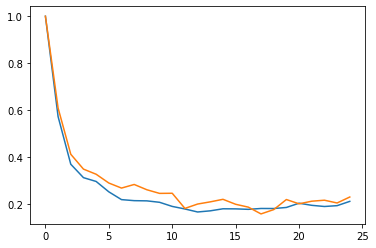

In [106]:
plt.plot(leads, corr_grid_train)
plt.plot(leads, corr_grid_test)